<a href="https://colab.research.google.com/github/mkatouda/qclsample/blob/master/qiskit_qcl_regression_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Qiskitによる量子回路学習のサンプルコード: １次関数の回帰問題**
量子機械学習にパラメータ化された量子回路(PQC)を適用しNISQ量子コンピュータで実行可能としたことでブレークスルーとなった手法として，大阪大学の御手洗らにより開発された量子回路学習(Quantum Cirquit Learning: QCL)[[Phys. Rev. A. 98, 032309 (2018)]](https://doi.org/10.1103/PhysRevA.98.032309)が挙げられる．
本ノートブックでは，量子回路学習アルゴリズムをIBMの量子コンピューティングSDKである[Qiskit](https://qiskit.org/)を用いて実装した例を紹介する．

## 量子回路学習アルゴリズム
以下1-6の手順で量子・古典ハイブリッド計算が行われる．2-4のプロセスは量子コンピュータで，1,5-6のプロセスは古典コンピュータでそれぞれ計算される．  

$$
\def\bra#1{\mathinner{\left\langle{#1}\right|}}
\def\ket#1{\mathinner{\left|{#1}\right\rangle}}
\def\braket#1{\mathinner{\left\langle{#1}\right\rangle}}
$$

1.   学習データ$\{(\mathbf{x}_i, \mathbf{y}_i)\}$, $\mathbf{x}_i$は入力データのベクトル, $\mathbf{y}_i$は出力データの真の値(教師データ)}を用意する．
2.   入力$\mathbf{x}$を量子状態に埋め込む量子回路$U_\text{in}(\mathbf{x}_i)$ (特徴量マップとよぶ)を設定し，$\mathbf{x}_i$のデータを入力量子状態$\ket{\psi_\text{in}(\mathbf{x}_i)}=U_\text{in}(\mathbf{x}_i)\ket{0}^{\otimes n}$($n$: 量子ビット数)として埋め込む．
3.   変分最適化により調整可能なパラメータを持つ量子回路$U_\text{out}(\mathbf{\theta})$を設定し，入力量子状態に作用させ，出力量子状態$\ket{\psi_\text{out}(\mathbf{x}_i,\mathbf{\theta})}= U_\text{out}(\mathbf{\theta})\ket{\psi_\text{in}(\mathbf{x}_i)}$を得る．
4.   出力量子状態に対し観測量の演算子(例えば、最初の量子ビット0のZ基底を測定するための射影演算子$\hat{Z}_0=\ket{0_0}\bra{0_0}+\ket{1_0}\bra{1_0}$の期待値$\braket{Z_0}=\bra{\psi_\text{out}}\hat{Z}_0\ket{\psi_\text{out}}$)を設定し，その測定値$\mathbf{y}(\mathbf{x}_i,\mathbf{\theta})$を得る．
5.   真の値$\mathbf{y}_i$と測定値$\mathbf{y}(\mathbf{x}_i,\mathbf{\theta})$間の乖離を表す損失関数$L(\mathbf{\theta})$を設定し，その値を極小化する方向に向かう$\mathbf{\theta}$の候補値に更新する．
6.   3-5のプロセスを繰り返し，損失関数$L(\mathbf{\theta})$を最小化するパラメータ$\mathbf{\theta}_\text{min}$を探索する．探索により得られたパラメータ$\mathbf{\theta}_\text{min}$を用いた$\mathbf{y}(\mathbf{x}_i,\mathbf{\theta}_\text{min})$を予測モデルとして採用する．

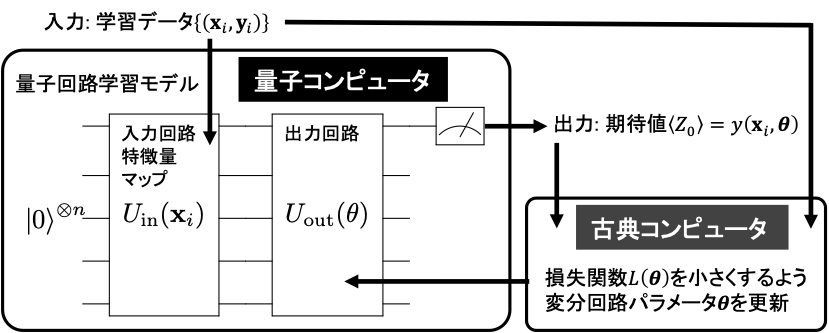

## 参考文献
1.   K. Mitarai, M. Negoro, M. Kitagawa, K. Fujii, Quantum circuit learning, Phys. Rev. A. 98, 032309 (2018). [DOI: 10.1103/PhysRevA.98.032309](https://doi.org/10.1103/PhysRevA.98.032309)
2.   T. Suzuki, M. Katouda, Predicting toxicity by quantum machine learning, J. Phys. Commun. 4, 125012 (2020). [DOI: 10.1088/2399-6528/abd3d8](https://doi.org/10.1088/2399-6528/abd3d8)
3.   御手洗 光祐, 藤井 啓祐, 量子コンピュータを用いた変分アルゴリズムと機械学習, 日本物理学会誌 74 (9), 604 (2019). [DOI: 10.11316/butsuri.74.9_604](https://www.jps.or.jp/books/gakkaishi/2019/09/74-09seriesAIphys1.pdf)
4.   河東田 道夫, ケモインフォマティクス実課題のための量子機械学習法の共同研究, RISTニュース No. 67 (2021). [記事pdf](https://www.rist.or.jp/rnews/67/67s3.pdf)

## Qiskitを用いた量子回路学習による回帰の実装例

Qiskitのインストール

In [1]:
!pip install qiskit[visualization]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.7 MB 4.0 MB/s 
     |████████████████████████████████| 19.2 MB 1.3 MB/s 
     |████████████████████████████████| 240 kB 47.8 MB/s 
     |████████████████████████████████| 162 kB 62.2 MB/s 
     |████████████████████████████████| 112 kB 41.9 MB/s 
     |████████████████████████████████| 55 kB 3.1 MB/s 
     |████████████████████████████████| 37.5 MB 1.3 MB/s 
     |████████████████████████████████| 943 kB 34.5 MB/s 
     |████████████████████████████████| 49 kB 5.7 MB/s 
     |████████████████████████████████| 49 kB 5.1 MB/s 
     |████████████████████████████████| 1.6 MB 39.7 MB/s 
     |████████████████████████████████| 4.0 MB 41.6 MB/s 
     |████████████████████████████████| 1.9 MB 44.7 MB/s 
     |████████████████████████████████| 112 kB 45.4 MB/s 
  Created wheel for qiskit: filename=qiskit-0.38.0-py3-none-any.whl size=12147 sha256=b17160cb7d

必要なモジュールのインポート

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, transpile
from qiskit.algorithms.optimizers import COBYLA

QCLモデルの入力パラメータの設定


In [3]:
########  パラメータ  #############
# 乱数のシード
random_seed = 0
# 乱数発生器の初期化
np.random.seed(random_seed)

# Qubit数，回路の深さ，期待値の増幅係数
nqubit = 2
c_depth = 5
Mfac = 2.0

# 量子コンピュータシミュレータの設定
backendname = 'aer_simulator'
num_shots = 8192

# パラメータオプティマイザの設定
maxiter = 100
tol = 0.05

回帰する元データの設定

In [4]:
########  学習データ  #############
# 回帰する関数の定義: y=sin(x)
func_to_learn = lambda x: np.sin(x*np.pi)

# 回帰データの設定
x_min = -1.; x_max = 1.; num_x_train = 100
x_train = x_min + (x_max - x_min) * np.random.rand(num_x_train)
y_train = func_to_learn(x_train)

x_pred = np.arange(x_min, x_max, 0.02)
y_pred = func_to_learn(x_pred)

# 関数に正規分布ノイズを付加
mag_noise = 0.05
y_train += mag_noise * np.random.randn(num_x_train)

回帰する元データの可視化

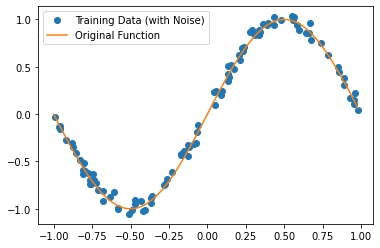

In [5]:
fig = plt.figure()
plt.plot(x_train, y_train, "o", label='Training Data (with Noise)')
plt.plot(x_pred, y_pred, label='Original Function')
plt.legend()
plt.show()
#plt.savefig('./inputdata-plot.png')

入力回路$U_\text{in}(x)$の設定: 入力回路は御手洗&藤井のQCLオリジナル論文[[Phys. Rev. A. 98, 032309 (2018)]](https://doi.org/10.1088/2399-6528/abd3d8)の回路($R_Y(\arcsin{x})-R_Z(\arccos(x^2)$)から鈴木&河東田の論文[[J. Phys. Commun. 4, 125012 (2020)]](https://doi.org/10.1088/2399-6528/abd3d8)で検討した最良モデルの回路($R_Y(x)-R_Z(x)-\text{CNOT}-R_Y(x)-R_Z(x)-\text{CNOT}$)へ変更

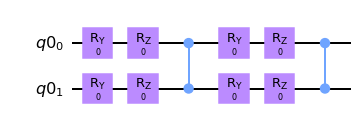

In [6]:
def U_in(x, nqubit):
    qr = QuantumRegister(nqubit)
    U = QuantumCircuit(qr)
    for j in range(2):
        for i in range(nqubit):
            U.ry(x, i)
            U.rz(x, i)
        for i in range(nqubit-1):
            U.cz(i, i+1)
        if nqubit >=3: U.cz(nqubit-1, 0)

    return U

U_in(0.0, nqubit).draw('mpl')

出力回路$U_\text{out}(\mathbf{\theta})$の設定

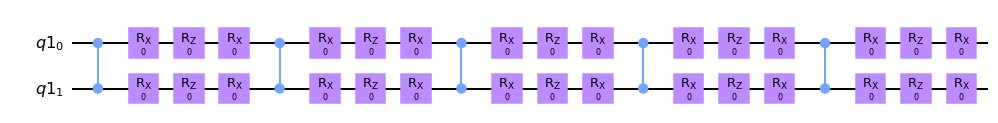

In [7]:
def U_out(nqubit, c_depth, params):
    qr = QuantumRegister(nqubit)
    U = QuantumCircuit(qr)
    for d in range(c_depth):
        for i in range(nqubit-1):
            U.cz(i, i+1)
        if nqubit >=3: U.cz(nqubit-1, 0)
        for i in range(nqubit):
            U.rx(params[nqubit*3*d+3*i], i)
            U.rz(params[nqubit*3*d+3*i+1], i)
            U.rx(params[nqubit*3*d+3*i+2], i)

    return U

num_vars = 3 * nqubit * c_depth
U_out(nqubit, c_depth, np.zeros(num_vars)).draw('mpl')

量子回路学習モデルの設定:  
観測量の演算子に密度演算子を用いた場合  

In [8]:
def pred_circ(x, nqubit, c_depth, params):
    qr = QuantumRegister(nqubit, name='q')
    cr = ClassicalRegister(1, name='c')
    qc = QuantumCircuit(qr, cr)
    u_in = U_in(x, nqubit).to_instruction()
    u_out = U_out(nqubit, c_depth, params).to_instruction()
    qc.append(u_in, qr)
    qc.append(u_out, qr)
    qc.measure(0, 0)

    return qc

def get_expval(qc, backendname, num_shots):
    backend = Aer.get_backend(backendname)
    qc = transpile(qc, backend=backend)
    result = backend.run(qc, shots=num_shots).result()
    counts = result.get_counts(qc)
    expval = (counts['0'] - counts['1']) / num_shots

    return expval

def qcl_reg(x_pred, nqubit, c_depth, params, Mfac, backendname, num_shots):
    y_pred = []
    for x in x_pred:
        qc = pred_circ(x, nqubit, c_depth, params)
        y_pred.append(Mfac*get_expval(qc, backendname, num_shots))

    return np.array(y_pred)

学習モデルの量子回路の可視化

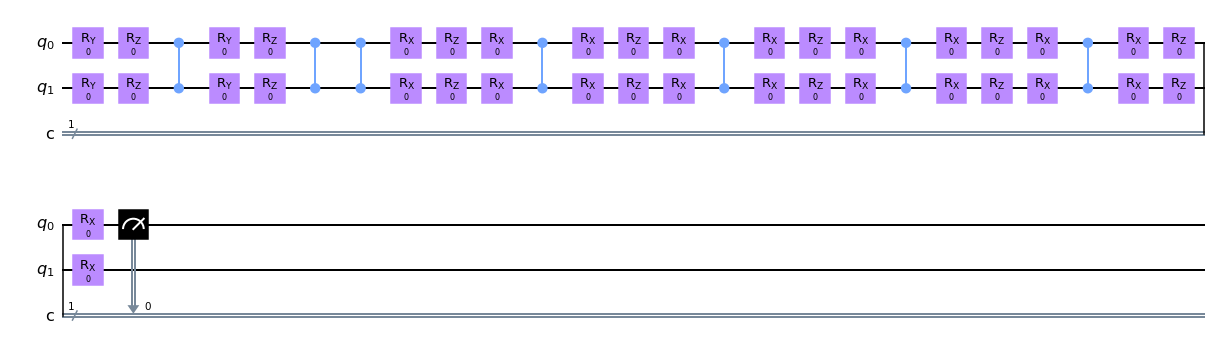

In [9]:
num_vars = 3 * nqubit * c_depth
pred_circ(0.0, nqubit, c_depth, np.zeros(num_vars)).decompose().draw('mpl')

出力回路$U_\text{out}(\mathbf{\theta})$の変分回路パラメータ$\mathbf{\theta}$の初期化

In [10]:
num_vars = 3 * nqubit * c_depth
params_init = np.random.rand(num_vars) * 2.0 * np.pi

初期化した変分回路パラメータ$\theta$を用いて回帰計算実行

In [11]:
print('Initial params\n', params_init)

y_pred_reg_init = qcl_reg(x_pred, nqubit, c_depth, params_init, Mfac, backendname, num_shots)
print('y_pred_reg_init:\n', y_pred_reg_init)

Initial params
 [1.30357293 2.6683775  2.35097932 2.9127303  1.74439261 3.68687478
 5.42776485 0.73847443 3.2507888  0.82980839 4.50416222 2.48851651
 3.55264688 1.15158117 0.91010531 3.06654805 2.23438073 5.90890818
 4.80868039 4.70399226 5.67823859 0.52415862 3.46952761 3.67237145
 6.04402452 1.83561705 1.51317185 0.63016542 0.10323041 5.84040495]
y_pred_reg_init:
 [-1.91894531 -1.88916016 -1.84521484 -1.81542969 -1.73388672 -1.67138672
 -1.59814453 -1.50048828 -1.41845703 -1.31640625 -1.22265625 -1.11035156
 -1.02148438 -0.90722656 -0.81347656 -0.68505859 -0.58105469 -0.49023438
 -0.40869141 -0.27734375 -0.17431641 -0.05224609  0.07470703  0.12353516
  0.27929688  0.27294922  0.33447266  0.4296875   0.53662109  0.59521484
  0.62695312  0.68652344  0.76660156  0.7578125   0.80371094  0.79785156
  0.8515625   0.8203125   0.84472656  0.83007812  0.83398438  0.80908203
  0.79052734  0.74658203  0.71972656  0.70605469  0.66699219  0.61767578
  0.58837891  0.53564453  0.45361328  0.432128

変分回路パラメータ学習用の損失関数の設定

In [12]:
def loss_function(params):
    loss_total = 0.0
    for i in range(len(x_train)):
        qc = pred_circ(x_train[i], nqubit, c_depth, params)
        loss = (y_train[i] - Mfac * get_expval(qc, backendname, num_shots))**2
        loss_total += loss

    return loss_total

def obj_function(params):
    global iter
    loss_total = loss_function(params)
    print('Iter: %d, Loss: %f' % (iter, loss_total))
    losses.append(loss_total)
    iter += 1

    return loss_total

パラメータシフト法を用いた損失関数の回路パラメータ微分計算  
(計算が遅いため，現バージョンでは回路パラメータ学習には使用していない)

In [13]:
def loss_grad(params):
    gradient = np.empty(len(params))
    shifted = params.copy()
    pipt = 0.5 * np.pi
    for i in range(len(params)):
        tmp = shifted[i]
        shifted[i] = tmp + pipt
        forward = loss_function(shifted)
        shifted[i] = tmp - pipt
        backward = loss_function(shifted)
        gradient[i] = 0.5 * (forward - backward)
        shifted[i] = tmp

    return gradient

変分回路パラメータ学習実行：回路パラメータの最適化アルゴリズムには  
[COBYLA(Constrained Optimization By Linear Approximation)法](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.COBYLA.html)を使用

In [14]:
iter = 0; losses = []
optimizer = COBYLA(maxiter=maxiter, tol=tol)
result = optimizer.minimize(obj_function, params_init)

Iter: 0, Loss: 111.651037
Iter: 1, Loss: 86.675475
Iter: 2, Loss: 78.103026
Iter: 3, Loss: 79.862534
Iter: 4, Loss: 48.319133
Iter: 5, Loss: 38.006034
Iter: 6, Loss: 24.560602
Iter: 7, Loss: 102.872722
Iter: 8, Loss: 40.714477
Iter: 9, Loss: 35.865713
Iter: 10, Loss: 49.451233
Iter: 11, Loss: 50.005896
Iter: 12, Loss: 96.300558
Iter: 13, Loss: 55.720041
Iter: 14, Loss: 13.192888
Iter: 15, Loss: 121.858836
Iter: 16, Loss: 43.033265
Iter: 17, Loss: 12.325874
Iter: 18, Loss: 49.150376
Iter: 19, Loss: 114.719335
Iter: 20, Loss: 3.772490
Iter: 21, Loss: 15.729260
Iter: 22, Loss: 123.483241
Iter: 23, Loss: 27.051256
Iter: 24, Loss: 94.050733
Iter: 25, Loss: 7.159241
Iter: 26, Loss: 70.572818
Iter: 27, Loss: 52.788798
Iter: 28, Loss: 3.821022
Iter: 29, Loss: 3.799649
Iter: 30, Loss: 3.856151
Iter: 31, Loss: 61.110662
Iter: 32, Loss: 1.914945
Iter: 33, Loss: 5.618155
Iter: 34, Loss: 16.952736
Iter: 35, Loss: 60.817625
Iter: 36, Loss: 18.056984
Iter: 37, Loss: 8.765050
Iter: 38, Loss: 3.960323


学習結果の表示

In [15]:
params_final = result.x
print('Final params\n', params_final)

y_pred_reg_final = qcl_reg(x_pred, nqubit, c_depth, params_final, Mfac, backendname, num_shots)
print('y_pred_reg_final:\n', y_pred_reg_final)

Final params
 [ 3.08900194  3.65960204  2.40827051  3.96204569  2.75857422  4.70443724
  5.58200348  0.64303679  3.20254424  0.6833514   4.47026023  2.34291089
  3.47660214  2.14161767  0.77940117  3.03749811  3.2423927   5.73173444
  4.99424737  5.71590844  5.65928914  0.29709969  3.4291064   3.50185612
  6.04165728  1.71095748  1.42251147  0.44497493 -0.02955375  5.61297378]
y_pred_reg_final:
 [ 9.76562500e-04 -6.25000000e-02 -1.86523438e-01 -2.47070312e-01
 -2.98828125e-01 -3.73046875e-01 -4.28222656e-01 -5.13671875e-01
 -5.21972656e-01 -6.07910156e-01 -6.71875000e-01 -7.03125000e-01
 -7.75390625e-01 -7.98828125e-01 -8.37890625e-01 -8.62304688e-01
 -8.63281250e-01 -9.16992188e-01 -8.98437500e-01 -9.65332031e-01
 -9.86328125e-01 -1.00146484e+00 -9.79003906e-01 -9.73632812e-01
 -9.96093750e-01 -1.01660156e+00 -9.74121094e-01 -9.70703125e-01
 -9.68750000e-01 -9.94140625e-01 -9.16015625e-01 -9.13574219e-01
 -8.74511719e-01 -8.82812500e-01 -8.33007812e-01 -8.12988281e-01
 -7.87597656e-01

損失関数の最適化結果の可視化

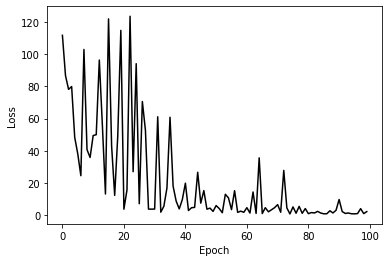

In [16]:
fig = plt.figure()
plt.plot([i for i in range(len(losses))], losses, c='black', linewidth=1.5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
#plt.savefig('./qcl-epoch.png')

量子回路学習で決定した回帰モデルの可視化

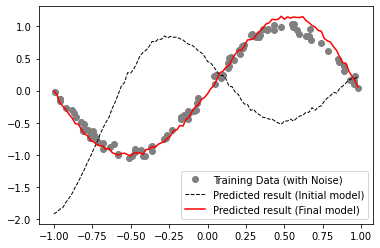

In [17]:
fig = plt.figure()
plt.plot(x_train, y_train, 'o', label='Training Data (with Noise)', c='gray')
plt.plot(x_pred, y_pred_reg_init, '--', label='Predicted result (Initial model)', c='black', linewidth=1.0)
plt.plot(x_pred, y_pred_reg_final, label='Predicted result (Final model)', c='red', linewidth=1.5)
plt.legend()
plt.show()
#plt.savefig('./qcl-regplot.png')